In [44]:
import pandas as pd
import numpy as np
from datetime import datetime
import pytz
import re

# 1. Function to convert epoch to a CST datetime object
def convert_epoch_to_cst_datetime(epoch, cst):
    utc_time = datetime.utcfromtimestamp(epoch).replace(tzinfo=pytz.utc)
    return utc_time.astimezone(cst)

# 2. Function to create 'submitInterval' column based on time of day
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# 3. Function to read CSV file
def read_csv(file_path):
    return pd.read_csv(file_path)

# 4. Function to convert 'submitTime', 'startTime', and 'endTime' to CST
def convert_time_columns(df, cst):
    df['submitTime'] = df['submitTime'].apply(lambda x: convert_epoch_to_cst_datetime(x, cst))
    df['startTime'] = df['startTime'].apply(lambda x: convert_epoch_to_cst_datetime(x, cst))
    df['endTime'] = df['endTime'].apply(lambda x: convert_epoch_to_cst_datetime(x, cst))
    return df

# 5. Function to calculate 'pendTime'
def calculate_pend_time(df):
    df['pendTime'] = (df['startTime'] - df['submitTime']).dt.total_seconds()
    return df

# 6. Function to add 'submitInterval' and 'submitDay' columns
def add_time_of_day_and_day(df):
    df['submitInterval'] = df['submitTime'].dt.hour.apply(get_time_of_day)
    df['submitDay'] = df['submitTime'].dt.day_name()
    return df

# 7. Function to overwrite 'queue' after replacing 'rhel8_' and 'rhel88_'
def overwrite_queue(df):
    df['queue'] = df['queue'].str.replace(r'rhel8_', '', regex=True)
    df['queue'] = df['queue'].str.replace(r'rhel88_', '', regex=True)
    return df

# 8. Function to extract memory from 'resReq' and overwrite existing values
def extract_requested_memory(df):
    df['resReq'] = df['resReq'].astype(str)
    df['requested_memory'] = df['resReq'].apply(lambda resReq: float(re.search(r'mem=(\d+(\.\d+)?)', resReq).group(1)) if re.search(r'mem=(\d+(\.\d+)?)', resReq) else None)
    return df.dropna(subset=['requested_memory'])

# 9. Function to convert 'maxRMem' from KB to MB
def convert_max_rmem(df):
    df['maxRMem'] = df['maxRMem'] / 1024
    return df

# 10. Function to create the 'userCancelJob' indicator variable
def create_user_cancel_job(df):
    df['userCancelJob'] = np.where(df['pendTime'] < 0, 1, 0)
    return df

# 11. Function to filter rows where 'userCancelJob' is greater than 0
def remove_user_cancel_job(df):
    return df[df['userCancelJob'] == 0]

# 12. Function to order the 'queue' variable based on value counts
def order_queue_by_value_counts(df):
    queue_counts = df['queue'].value_counts()
    ordered_queues = queue_counts.index
    df['queue'] = pd.Categorical(df['queue'], categories=ordered_queues, ordered=True)
    return df

# 13. Main preprocessing function
def preprocess_csv(file_path):
    cst = pytz.timezone('US/Central')  # Define CST timezone
    
    # Step-by-step preprocessing
    df = read_csv(file_path)
    df = convert_time_columns(df, cst)
    df = calculate_pend_time(df)
    df = add_time_of_day_and_day(df)
    df = overwrite_queue(df)
    df = extract_requested_memory(df)
    df = convert_max_rmem(df)
    df = create_user_cancel_job(df)
    df = remove_user_cancel_job(df)  # Keep only rows where userCancelJob > 0
    df = order_queue_by_value_counts(df)  # Order the 'queue' column by value counts
    
    # Display the filtered dataframe
    #print(df.head())
    #print(df.shape[0])
    
    return df


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Function to draw a histogram for any variable between startTime and endTime
def plot_histogram(df, variable, start_time, end_time, save_folder="visualization_time/", logX=False, logY=False):
    # Convert start_time and end_time to datetime objects
    start_time = pd.to_datetime(start_time).date()  # Only keep the date
    end_time = pd.to_datetime(end_time).date()      # Only keep the date

    # Filter the dataframe based on the startTime and endTime
    df_filtered = df[(df['startTime'].dt.date >= start_time) & (df['endTime'].dt.date <= end_time)]

    # Check if the variable exists in the dataframe
    if variable not in df_filtered.columns:
        print(f"Error: Variable '{variable}' not found in the dataframe.")
        return

    # Check if the variable is categorical
    is_categorical = df_filtered[variable].dtype == 'object' or pd.api.types.is_categorical_dtype(df_filtered[variable])

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(df_filtered[variable], bins=30, kde=True) if not is_categorical else sns.histplot(df_filtered[variable], kde=False)

    # Set log scale options
    if logX:
        plt.xscale('log')
    if logY:
        plt.yscale('log')
    
    # Set the title with only the date (not datetime)
    plt.title(f'Histogram of {variable} from {start_time} to {end_time}')
    plt.xlabel(variable + (' (Log Scale)' if logX else ''))
    plt.ylabel('Frequency' + (' (Log Scale)' if logY else ''))

    # Rotate x-axis labels if the variable is categorical
    if is_categorical:
        plt.xticks(rotation=90)

    plt.grid(True)

    # Check if the folder exists, if not, create it
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # Save the plot with a filename based on the variable and the date range
    log_suffix = ('_logX' if logX else '') + ('_logY' if logY else '')
    file_name = f"{variable}_histogram_{start_time}_to_{end_time}{log_suffix}.png"
    file_path = os.path.join(save_folder, file_name)

    # Save and show the plot
    plt.savefig(file_path)
    plt.show()

    print(f"Histogram saved as: {file_path}")


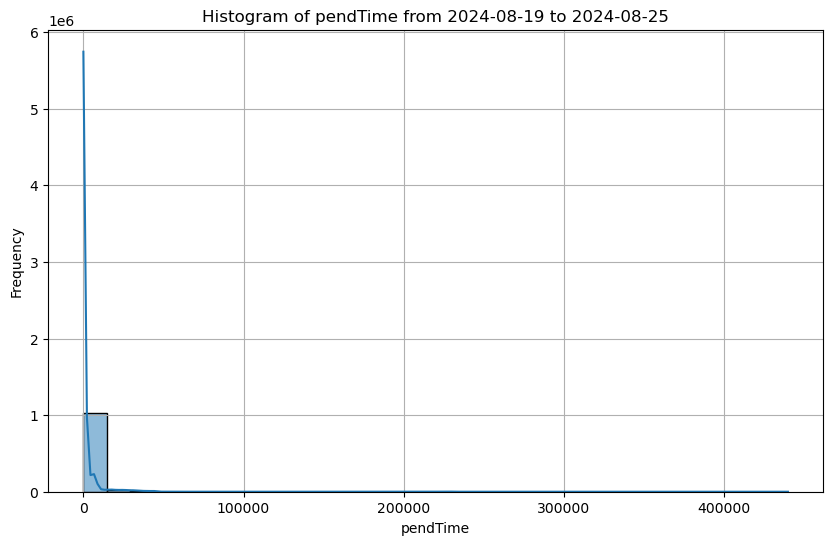

Histogram saved as: visualization_time/pendTime_histogram_2024-08-19_to_2024-08-25.png


In [35]:
# Example usage:
file_path = '../common/finished_jobs_1_week.csv'
df_preprocessed = preprocess_csv(file_path)
##print(df_preprocessed.head())


# Specify the variable you are interested in (e.g., 'pendTime') and the time range
start_time = '2024-08-19 00:00:00-05:00'
end_time = '2024-08-25 23:59:59-05:00'
variable_of_interest = 'pendTime'

# Plot the histogram
plot_histogram(df_preprocessed, variable_of_interest, start_time, end_time, save_folder="visualization_time/", logX=False, logY=False)


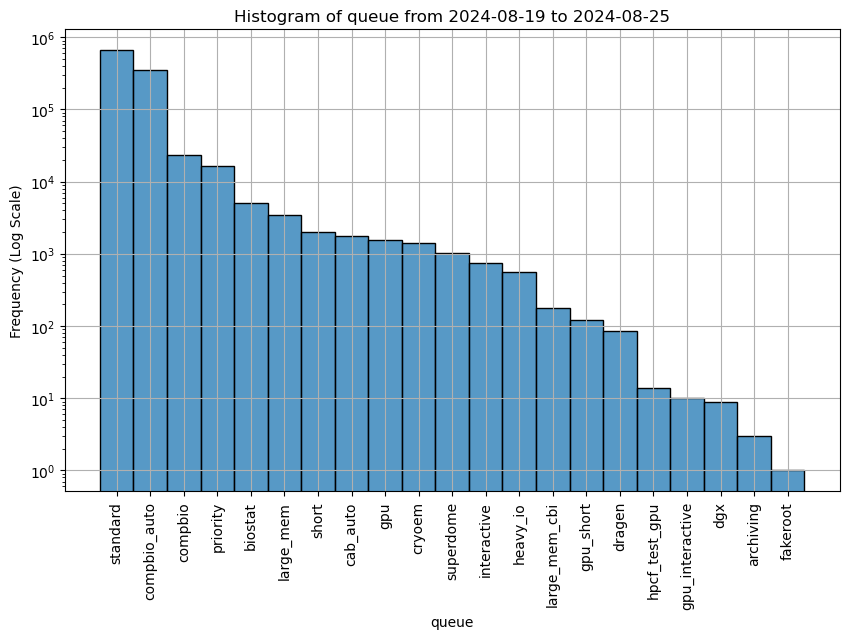

Histogram saved as: visualization_time/queue_histogram_2024-08-19_to_2024-08-25_logY.png


In [43]:
# Plot the histogram
variable_of_interest='queue'
plot_histogram(df_preprocessed, variable_of_interest, start_time, end_time, save_folder="visualization_time/", logX=False, logY=True)


In [49]:
import pandas as pd

def summary_statistics_of_var_by_group(df, var_interest, start_time, end_time, group_by_var):
    # Convert start_time and end_time to datetime objects
    start_time = pd.to_datetime(start_time).date()
    end_time = pd.to_datetime(end_time).date()
    
    # Filter the dataframe based on the startTime and endTime
    df_filtered = df[(df['startTime'].dt.date >= start_time) & (df['endTime'].dt.date <= end_time)]
    
    # Check if the additional grouping variable exists in the dataframe
    if group_by_var not in df_filtered.columns:
        print(f"Error: Grouping variable '{group_by_var}' not found in the dataframe.")
        return
    
    # Group by the additional grouping variable and calculate summary statistics for 'var_interest'
    summary = df_filtered.groupby(group_by_var)[var_interest].agg([
        'mean', 
        'median', 
        'min', 
        'max', 
        'std', 
        lambda x: x.quantile(0.25),  # 25th percentile
        lambda x: x.quantile(0.75),   # 75th percentile
        'sum'                        # Sum of values
    ])
    
    # Rename the quantile columns
    summary.columns = [
        'Mean', 
        'Median', 
        'Min', 
        'Max', 
        'Std Dev', 
        '25th Percentile', 
        '75th Percentile',
        'Summation'
    ]
    
    return summary


In [61]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_summary_statistics_of_var_by_group(summary_stats, var_interest, start_time, end_time, group_by_var, save_folder = 'visualization_time/'):
    # Convert start_time and end_time to date strings for use in titles and filenames
    start_time_str = pd.to_datetime(start_time).strftime('%Y-%m-%d')
    end_time_str = pd.to_datetime(end_time).strftime('%Y-%m-%d')

    # Plot for Median, 25th Percentile, and 75th Percentile
    plt.figure(figsize=(12, 6))
    plt.plot(summary_stats.index, summary_stats['Median'], label='Median', marker='o')
    plt.plot(summary_stats.index, summary_stats['25th Percentile'], label='25th Percentile', marker='o')
    plt.plot(summary_stats.index, summary_stats['75th Percentile'], label='75th Percentile', marker='o')


    # Adding dummy confidence intervals for illustration (replace with actual calculations)
    IQR = summary_stats['75th Percentile']-summary_stats['25th Percentile']  # Example CI calculation
    lower_ci = summary_stats['Median'] - 1.5 * IQR
    upper_ci = summary_stats['Median'] + 1.5 * IQR

    plt.fill_between(summary_stats.index, lower_ci, upper_ci, color='gray', alpha=0.2, label='95% CI')

    plt.xlabel(f'{group_by_var}')
    plt.ylabel('Values')
    plt.title(f'Median, 25th and 75th Percentiles of {var_interest} by {group_by_var} from {start_time_str} to {end_time_str}')
    plt.legend()
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    
    # Ensure the visualization directory exists
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    
    plt.savefig(f'{save_folder}{var_interest}_by_{group_by_var}_quantiles_{start_time_str}_to_{end_time_str}.png')
    plt.show()

    # Plot for Mean
    plt.figure(figsize=(12, 6))
    plt.plot(summary_stats.index, summary_stats['Mean'], label='Mean', color='red', marker='o')


        # Adding dummy confidence intervals for illustration (replace with actual calculations)
    
    lower_mean_ci = summary_stats['Mean'] - 1.96 * summary_stats['Std Dev']
    upper_mean_ci = summary_stats['Mean'] + 1.96 * summary_stats['Std Dev']
    plt.fill_between(summary_stats.index, lower_mean_ci, upper_mean_ci, color='gray', alpha=0.2, label='95% CI')
    
    plt.xlabel(f'{group_by_var}')
    plt.ylabel('Mean Value')
    plt.title(f'Mean of {var_interest} by {group_by_var} from {start_time_str} to {end_time_str}')
    plt.legend()
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    
    plt.savefig(f'{save_folder}{var_interest}_by_{group_by_var}_mean_{start_time_str}_to_{end_time_str}.png')
    plt.show()

    # Plot for Summation
    plt.figure(figsize=(12, 6))
    plt.plot(summary_stats.index, summary_stats['Summation'], label='Summation', color='purple', marker='o')
    plt.xlabel(f'{group_by_var}')
    plt.ylabel('Summation Value')
    plt.title(f'Summation of {var_interest} by {group_by_var} from {start_time_str} to {end_time_str}')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    
    plt.savefig(f'{save_folder}{var_interest}_by_{group_by_var}_summation_{start_time_str}_to_{end_time_str}.png')
    plt.show()


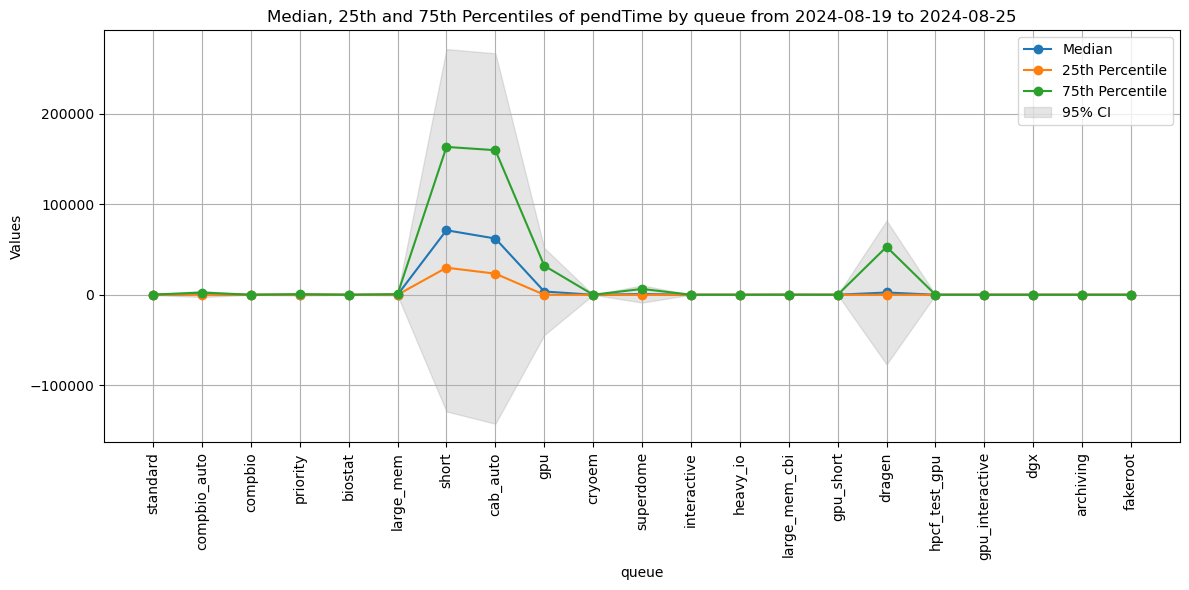

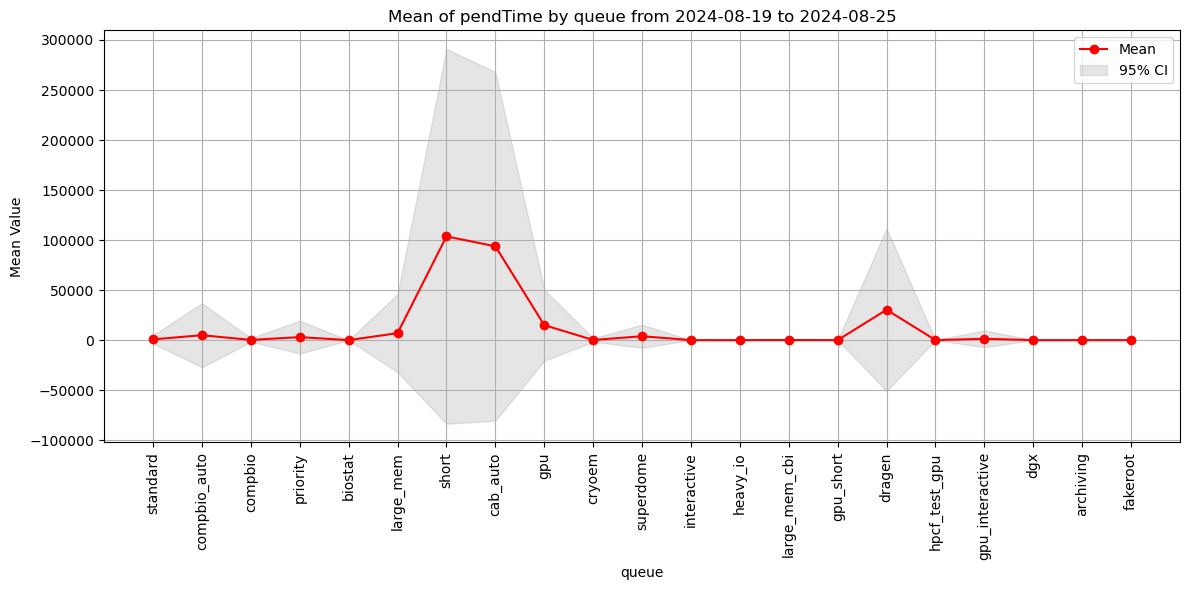

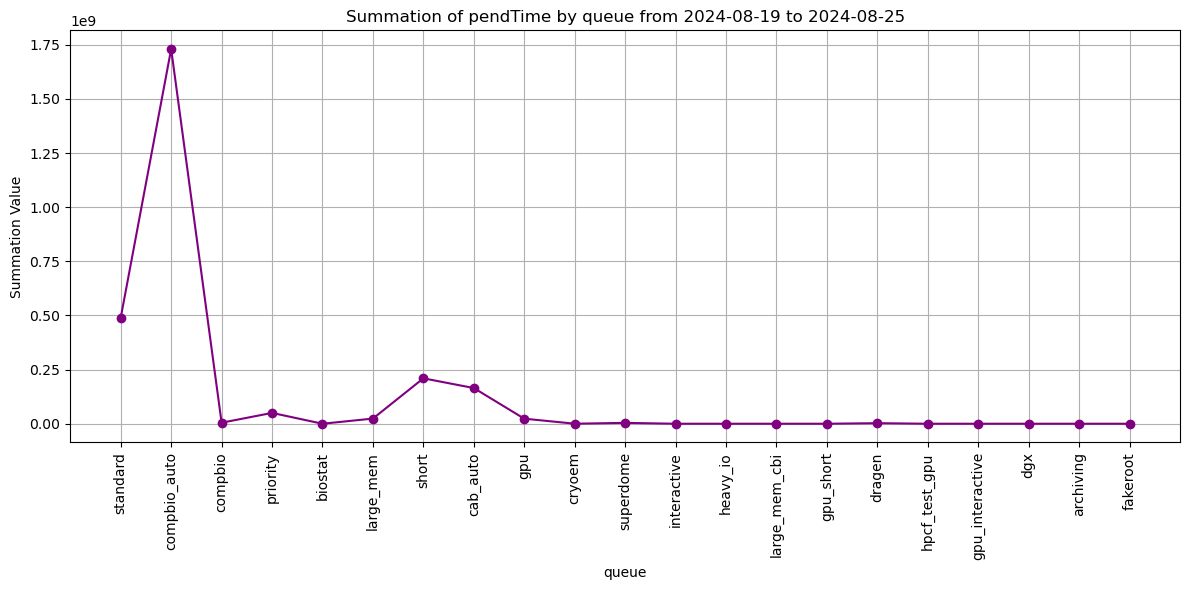

In [62]:
# Example usage:
start_time = '2024-08-19 00:00:00-05:00'
end_time = '2024-08-25 23:59:59-05:00'
variable_of_interest = 'pendTime' ## or 'runTime' or 'cpuTime'
grouping_variable = 'queue'  # Replace with your actual column name


file_path = '../common/finished_jobs_1_week.csv'
df_preprocessed = preprocess_csv(file_path)
# Assuming df_preprocessed is your DataFrame
summary_stats = summary_statistics_of_var_by_group(df_preprocessed, variable_of_interest, start_time, end_time, grouping_variable)
plot_summary_statistics_of_var_by_group(summary_stats, variable_of_interest, start_time, end_time, grouping_variable, save_folder)

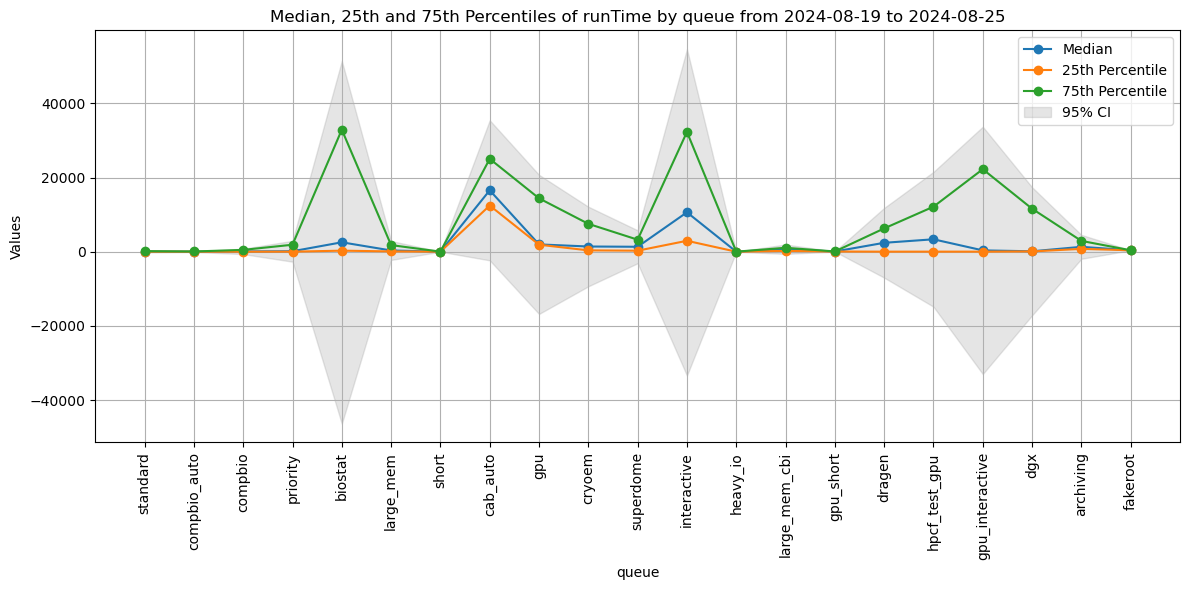

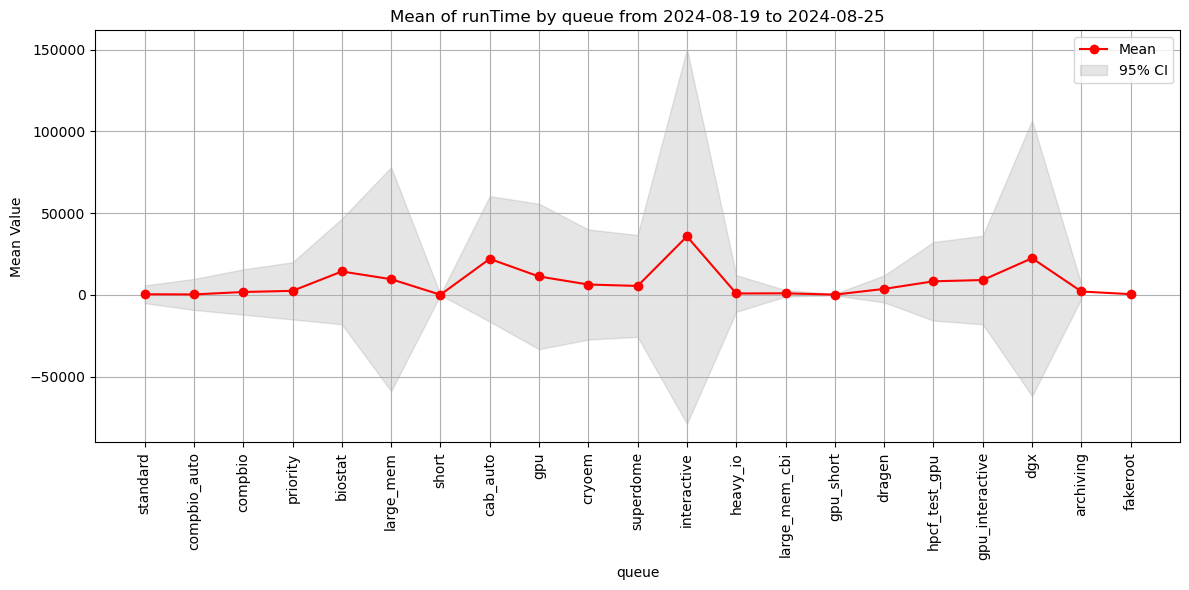

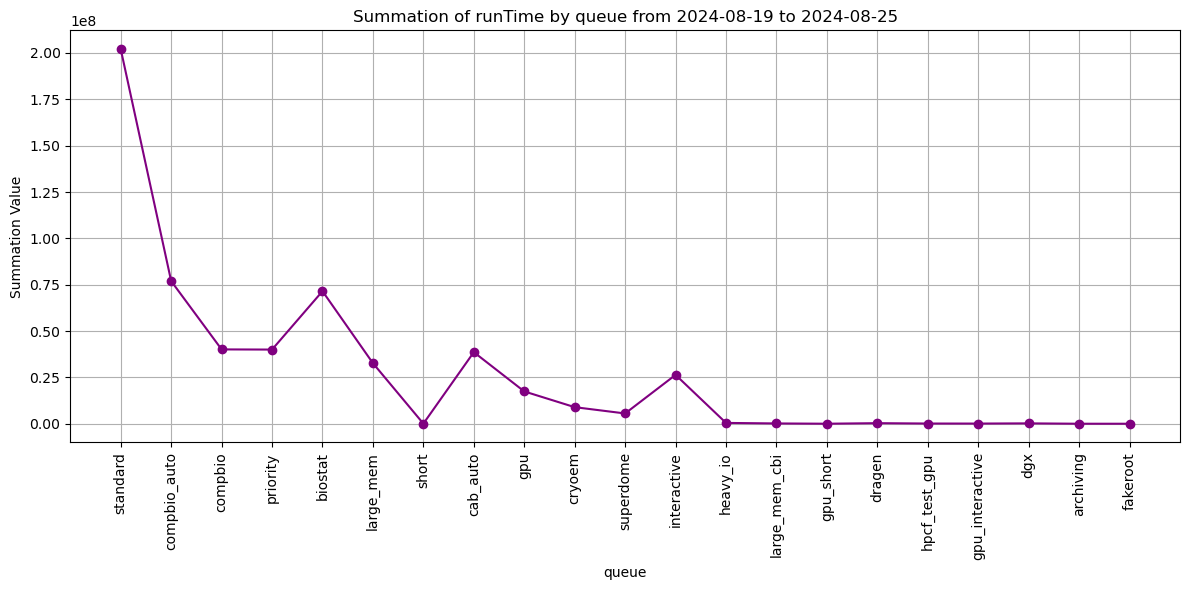

In [63]:
# Example usage:
start_time = '2024-08-19 00:00:00-05:00'
end_time = '2024-08-25 23:59:59-05:00'
variable_of_interest = 'runTime' ## or 'runTime' or 'cpuTime'
grouping_variable = 'queue'  # Replace with your actual column name


file_path = '../common/finished_jobs_1_week.csv'
df_preprocessed = preprocess_csv(file_path)
# Assuming df_preprocessed is your DataFrame
summary_stats = summary_statistics_of_var_by_group(df_preprocessed, variable_of_interest, start_time, end_time, grouping_variable)
plot_summary_statistics_of_var_by_group(summary_stats, variable_of_interest, start_time, end_time, grouping_variable, save_folder)

In [73]:
import pandas as pd
import numpy as np

def summary_statistics_of_variable_by_timebin(df, var_interest, start_time, end_time, time_bin):
    # Convert start_time and end_time to datetime objects
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)
    
    # Ensure 'startTime' is in datetime format
    df['startTime'] = pd.to_datetime(df['startTime'])
    
    # Filter the dataframe based on the startTime and endTime
    df_filtered = df[(df['startTime'] >= start_time) & (df['startTime'] <= end_time)]
    
    # Create time intervals
    bins = pd.date_range(start=start_time, end=end_time, freq=time_bin)
    
    # Add interval column
    df_filtered['interval'] = pd.cut(df_filtered['startTime'], bins=bins, right=False)
    
    # Calculate summary statistics for each interval
    summary = df_filtered.groupby('interval')[var_interest].agg([
        'mean', 
        'median', 
        'min', 
        'max', 
        'std', 
        lambda x: x.quantile(0.25),  # 25th percentile
        lambda x: x.quantile(0.75),   # 75th percentile
        'sum'
    ])
    
    # Rename the quantile columns
    summary.columns = [
        'Mean', 
        'Median', 
        'Min', 
        'Max', 
        'Std Dev', 
        '25th Percentile', 
        '75th Percentile',
        'Summation'
    ]
    
    return summary


                                                    Mean   Median  Min  \
interval                                                                 
[2024-08-19, 2024-08-19 02:00:00)           30198.577778  34740.0  426   
[2024-08-19 02:00:00, 2024-08-19 04:00:00)    537.341085     11.0    1   
[2024-08-19 04:00:00, 2024-08-19 06:00:00)     56.414365     15.0    0   
[2024-08-19 06:00:00, 2024-08-19 08:00:00)    473.988831     63.0    2   
[2024-08-19 08:00:00, 2024-08-19 10:00:00)    552.333436      6.0    1   
...                                                  ...      ...  ...   
[2024-08-25 12:00:00, 2024-08-25 14:00:00)   2634.554502   1547.0    6   
[2024-08-25 14:00:00, 2024-08-25 16:00:00)    282.402046     68.0    0   
[2024-08-25 16:00:00, 2024-08-25 18:00:00)    107.174633     65.0    1   
[2024-08-25 18:00:00, 2024-08-25 20:00:00)    102.536164     61.0    0   
[2024-08-25 20:00:00, 2024-08-25 22:00:00)    173.872379     55.0    2   

                                     

In [82]:
# Example usage of summary_statistics_of_variable_by_timebin
if __name__ == "__main__":
    # Load the CSV file into a pandas DataFrame
    start_time = '2024-08-19 00:00:00-05:00'
    end_time = '2024-08-25 23:59:59-05:00'
    variable_of_interest = 'runTime' ## or 'runTime' or 'cpuTime'

    file_path = '../common/finished_jobs_1_week.csv'
    df_preprocessed = preprocess_csv(file_path)
# Assuming df_preprocessed is your DataFrame
    # Call the function for 'runTime'
    stats = summary_statistics_of_variable_by_timebin(df_preprocessed, variable_of_interest, start_time, end_time, '2H')
    print(stats)

                                                    Mean   Median  Min  \
interval                                                                 
[2024-08-19, 2024-08-19 02:00:00)           30198.577778  34740.0  426   
[2024-08-19 02:00:00, 2024-08-19 04:00:00)    537.341085     11.0    1   
[2024-08-19 04:00:00, 2024-08-19 06:00:00)     56.414365     15.0    0   
[2024-08-19 06:00:00, 2024-08-19 08:00:00)    473.988831     63.0    2   
[2024-08-19 08:00:00, 2024-08-19 10:00:00)    552.333436      6.0    1   
...                                                  ...      ...  ...   
[2024-08-25 12:00:00, 2024-08-25 14:00:00)   2634.554502   1547.0    6   
[2024-08-25 14:00:00, 2024-08-25 16:00:00)    282.402046     68.0    0   
[2024-08-25 16:00:00, 2024-08-25 18:00:00)    107.174633     65.0    1   
[2024-08-25 18:00:00, 2024-08-25 20:00:00)    102.536164     61.0    0   
[2024-08-25 20:00:00, 2024-08-25 22:00:00)    173.872379     55.0    2   

                                     